In [ ]:
from pathlib import Path
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.patches import Circle
import xclimate as xclim

In [ ]:
%load_ext autoreload
%autoreload 2

%aimport xclimate

# cor(SM, Tr)

In [ ]:
cluster_client = xclim.create_dask_cluster(
    account="UWAS0155",
    nworkers=4,
    ncores=1,
    nmem="16GB",
    walltime="01:00:00",
)

account:  UWAS0155
nworkers: 4
ncores:   1
nmemory:  16GB
walltime: 01:00:00
{'PBSCluster-3': <dask_jobqueue.pbs.PBSJob: status=running>, 'PBSCluster-2': <dask_jobqueue.pbs.PBSJob: status=running>, 'PBSCluster-0': <dask_jobqueue.pbs.PBSJob: status=running>, 'PBSCluster-1': <dask_jobqueue.pbs.PBSJob: status=running>}

To view the dask dashboard
Run the following command in your local terminal:
> ssh -N -L 8787:128.117.211.160:8787 bbuchovecky@casper.hpc.ucar.edu
Open the following link in your local browser:
> http://localhost:8787/status


In [ ]:
variables = [
    "PRECC_month_1", "PRECL_month_1",
    "TSA_month_1",
    "EFLX_LH_TOT_month_1",
    "FCTR_month_1",
    "TLAI_month_1",
    "SOILWATER_10CM_month_1",
    "TOTSOILLIQ_month_1",
    "FSDS_month_1", "FSR_month_1", "FLDS_month_1", "FIRE_month_1",  # for net radiation
]

time_slice = slice("1995-01", "2014-12")
year_start = time_slice.start[:4]
year_end = time_slice.stop[:4]
grid = xclim.load_fhist_ppe_grid()

snow_pct_threshold = 80    # maximum allowable percent of snow cover on all months of the average year
nonglc_pct_threshold = 80  # maximum allowable percent of glaciated land for a NON-glaciated gridcell

fsno = xclim.load_fhist("FSNO_month_1", keep_var_only=True)["FSNO"].sel(time=time_slice).reindex_like(grid, method="nearest", tolerance=1e-3)
fsno_clim_min = fsno.groupby("time.month").mean().min(dim="month")

# Create masks
snow_mask = fsno_clim_min <= (snow_pct_threshold / 100)
nonglc_mask = grid.PCT_GLC <= nonglc_pct_threshold
full_mask = snow_mask & nonglc_mask

fhist = {}
for v in variables:
    print(f"  {v}")
    name = "_".join(v.split("_")[:-2])
    fhist[v] = xclim.load_fhist(v, keep_var_only=True)[name].reindex_like(grid, method="nearest", tolerance=1e-3)
    fhist[v] = fhist[v].where(full_mask)
    if v not in ["FCTR_month_1", "SOILWATER_10CM_month_1", "TOTSOILLIQ_month_1"]:
        fhist[v] = fhist[v].sel(time=time_slice)
    fhist[v] = fhist[v].chunk({"time": -1, "member": -1, "lat": -1, "lon": -1})
    fhist[v].attrs["masks"] = f"gridcell percent glaciated land <= {nonglc_pct_threshold}\ngridcell percent snow cover on all months of average year <= {snow_pct_threshold}"


# Monthly PRECT (PRECC + PRECL)
print("  PRECT_month_1")
fhist["PRECT_month_1"] = fhist["PRECC_month_1"] + fhist["PRECL_month_1"]
fhist["PRECT_month_1"].attrs["long_name"] = "total monthly precipitation rate (PRECC + PRECL)"
fhist.pop("PRECC_month_1")
fhist.pop("PRECL_month_1")


# Monthly net radiation at the surface, + down
#   Rn = (net SW) + (net LW) = (down SW - up SW) - (down LW - up LW)
#   Rn = FSDS - FSR + FLDS - FIRE
print("  RN_month_1")
fhist["RN_month_1"] = fhist["FSDS_month_1"] - fhist["FSR_month_1"] + fhist["FLDS_month_1"] - fhist["FIRE_month_1"]
fhist["RN_month_1"] = fhist["RN_month_1"].rename("RN")
fhist["RN_month_1"].attrs = {
    "long_name": "net radiation at surface [+ down]",
    "description": "FSDS - FSR + FLDS - FIRE",
    "units": "W/m2",
}

drop_variables = [
    "FSDS_month_1",
    "FSR_month_1",
    "FLDS_month_1",
    "FIRE_month_1",
]
for v in drop_variables:
    try:
        fhist.pop(v)
    except KeyError:
        continue

  PRECC_month_1
  PRECL_month_1
  TSA_month_1
  EFLX_LH_TOT_month_1
  FCTR_month_1
  TLAI_month_1
  SOILWATER_10CM_month_1
  TOTSOILLIQ_month_1
  FSDS_month_1
  FSR_month_1
  FLDS_month_1
  FIRE_month_1
  PRECT_month_1
  RN_month_1


In [ ]:
print("\nComputing annual mean:")
for v in list(fhist.keys()):
    if "month" in v:
        name = "_".join(v.split("_")[:-2])
        print(f"  {name}_year_1")
        fhist[f"{name}_year_1"] = fhist[f"{name}_month_1"].groupby("time.year").map(lambda x: x.weighted(x.time.dt.days_in_month).mean("time"))
        fhist[f"{name}_year_1"] = fhist[f"{name}_year_1"].chunk({"year": -1}).persist()


Computing annual mean:
  TSA_year_1
  EFLX_LH_TOT_year_1
  FCTR_year_1
  TLAI_year_1
  SOILWATER_10CM_year_1
  TOTSOILLIQ_year_1
  FSDS_year_1
  FSR_year_1
  FLDS_year_1
  FIRE_year_1
  PRECT_year_1


/glade/work/bbuchovecky/miniforge3/envs/data-sci-py312/lib/python3.12/site-packages/distributed/client.py:3387: UserWarning: Sending large graph of size 9.86 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


  RN_year_1


/glade/work/bbuchovecky/miniforge3/envs/data-sci-py312/lib/python3.12/site-packages/distributed/client.py:3387: UserWarning: Sending large graph of size 16.50 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


In [ ]:
print("Computing climatological mean:")
variables_clim = ["RN", "PRECT", "SOILWATER_10CM", "TOTSOILLIQ"]
for name in variables_clim:
    if f"{name}_year_1" in fhist.keys():
        print(f"  {name}_clim_1")
        fhist[f"{name}_clim_1"] = fhist[f"{name}_month_1"].weighted(fhist[f"{name}_month_1"].time.dt.days_in_month).mean("time")
        fhist[f"{name}_clim_1"].attrs["time_mean"] = f"{time_slice.start} to {time_slice.stop}"
    elif f"{name}_month_1" in fhist.keys():
        print(f"  {name}_clim_1")
        fhist[f"{name}_clim_1"] = fhist[f"{name}_year_1"].mean("year")
        fhist[f"{name}_clim_1"].attrs["time_mean"] = f"{time_slice.start} to {time_slice.stop}"
    else:
        print(f"  {name} not loaded")

Computing climatological mean:
  RN_clim_1
  PRECT_clim_1
  SOILWATER_10CM_clim_1
  TOTSOILLIQ_clim_1


In [ ]:
ai_rn_pr = fhist["RN_clim_1"] / (fhist["PRECT_clim_1"] * 1000 * 2.5e6)
ai_rn_pr = ai_rn_pr.compute()

/glade/work/bbuchovecky/miniforge3/envs/data-sci-py312/lib/python3.12/site-packages/distributed/client.py:3387: UserWarning: Sending large graph of size 22.91 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


In [ ]:
ai_pr_rn = 1 / ai_rn_pr
ai_pr_rn = ai_pr_rn.compute()

In [ ]:
def detrend(da, dim):
    # TODO: rechunk to dim is a single chunk
    regress = xclim.regression.ols_field(da[dim],  da, sample_dim=dim)
    trend = regress.intercept + da[dim] * regress.slope
    return da - trend

In [ ]:
smsfc_detrend = detrend(fhist["SOILWATER_10CM_year_1"], "year").persist()

In [ ]:
smtot_detrend = detrend(fhist["TOTSOILLIQ_year_1"], "year").persist()

In [ ]:
fctr_detrend = detrend(fhist["FCTR_year_1"], "year").persist()

In [ ]:
smtot_fctr_regr = xclim.regression.ols_field(smtot_detrend, fctr_detrend, "year", alpha=0.05)

In [ ]:
smsfc_fctr_regr = xclim.regression.ols_field(smsfc_detrend, fctr_detrend, "year", alpha=0.05)

In [ ]:
smtot_fctr_regr = smtot_fctr_regr.compute()

In [ ]:
smsfc_fctr_regr = smsfc_fctr_regr.compute()

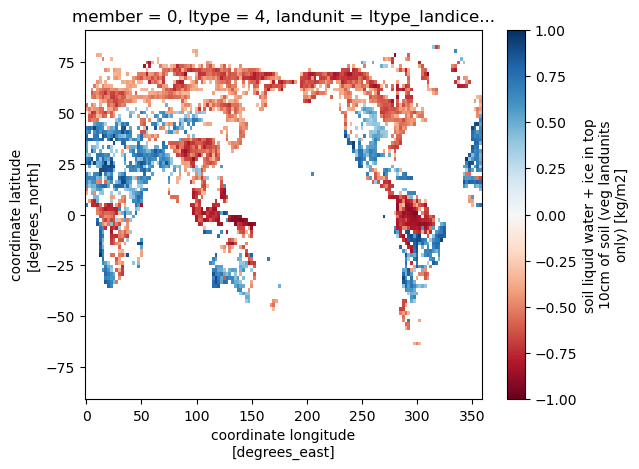

In [ ]:
smsfc_fctr_regr.pearsonr_fdr_masked.sel(member=0).plot(vmin=-1, vmax=1, cmap="RdBu")

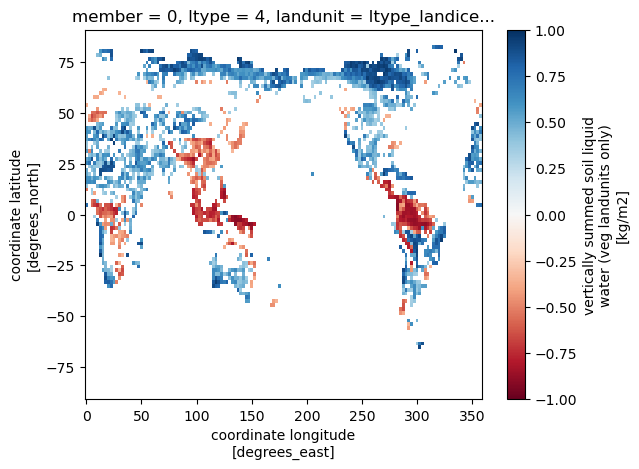

In [ ]:
smtot_fctr_regr.pearsonr_fdr_masked.sel(member=0).plot(vmin=-1, vmax=1, cmap="RdBu")

Text(0.5, 1.0, 'AI = P / R_net')

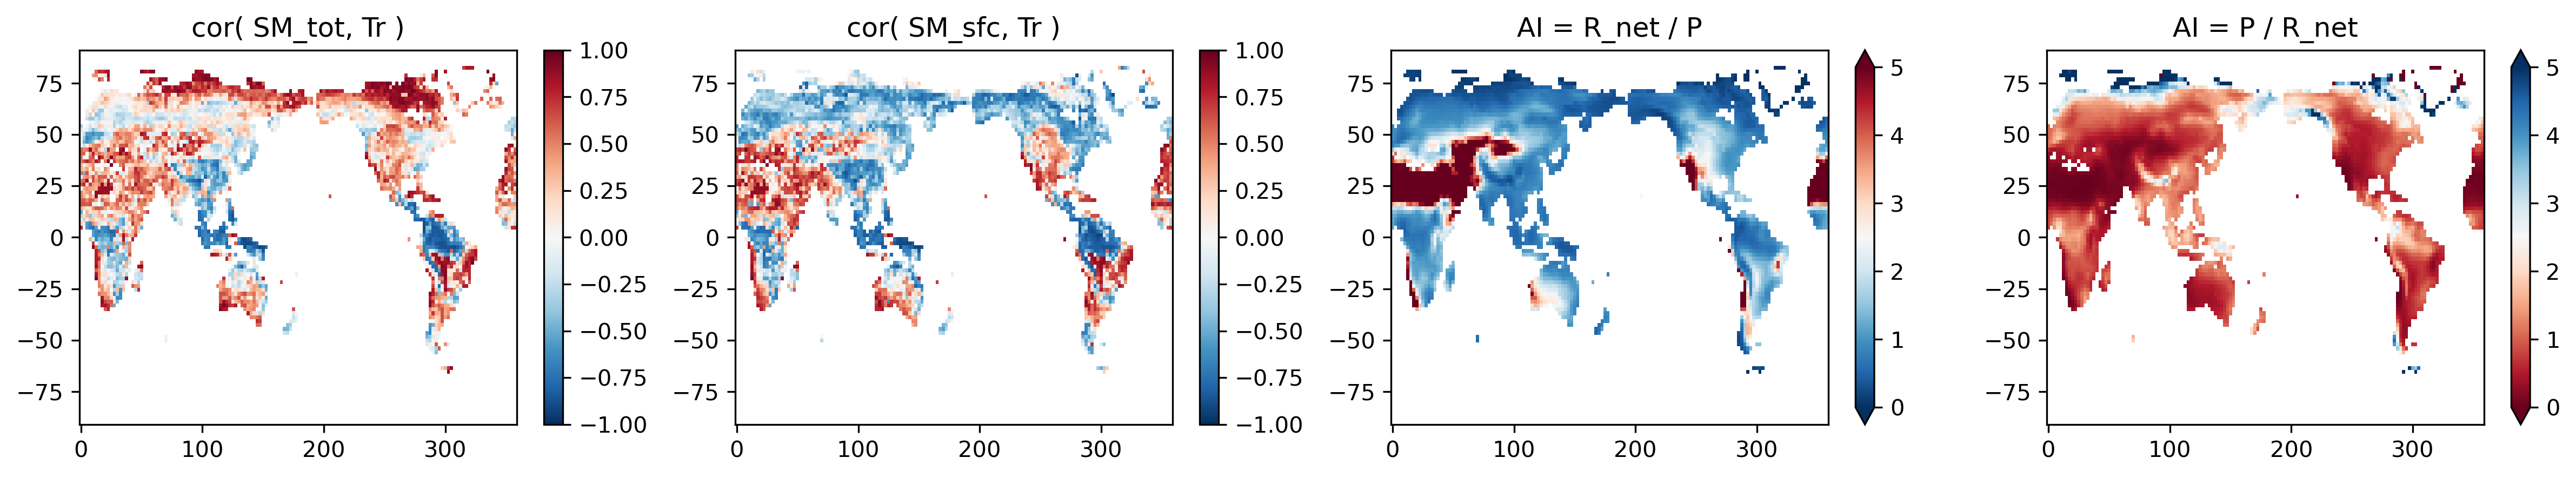

In [ ]:
m = 0

fig, ax = plt.subplots(1, 4, figsize=(20, 3), dpi=300)
smtot_fctr_regr.pearsonr.sel(member=m).plot.pcolormesh(ax=ax[0], add_labels=False, vmin=-1, vmax=1, cmap="RdBu_r")
smsfc_fctr_regr.pearsonr.sel(member=m).plot.pcolormesh(ax=ax[1], add_labels=False, vmin=-1, vmax=1, cmap="RdBu_r")
ai_rn_pr.sel(member=m).plot.pcolormesh(ax=ax[2], add_labels=False, vmin=0, vmax=5, cmap="RdBu_r")
ai_pr_rn.sel(member=m).plot.pcolormesh(ax=ax[3], add_labels=False, vmin=0, vmax=5, cmap="RdBu")

ax[0].set_title("cor( SM_tot, Tr )")
ax[1].set_title("cor( SM_sfc, Tr )")
ax[2].set_title("AI = R_net / P")
ax[3].set_title("AI = P / R_net")

In [ ]:
m = 0

fig, ax = plt.subplots(1, 4, figsize=(20, 3))
smtot_fctr_regr.pearsonr.where(~np.isnan(smtot_fctr_regr.slope_fdr_masked)).sel(member=m).plot.pcolormesh(ax=ax[0], add_labels=False, vmin=-1, vmax=1, cmap="RdBu_r")
smsfc_fctr_regr.pearsonr.where(~np.isnan(smsfc_fctr_regr.slope_fdr_masked)).sel(member=m).plot.pcolormesh(ax=ax[1], add_labels=False, vmin=-1, vmax=1, cmap="RdBu_r")
ai_rn_pr.sel(member=m).plot.pcolormesh(ax=ax[2], add_labels=False, vmin=0, vmax=5, cmap="RdBu_r")
ai_pr_rn.sel(member=m).plot.pcolormesh(ax=ax[3], add_labels=False, vmin=0, vmax=5, cmap="RdBu")

ax[0].set_title("cor( SM_tot, Tr )")
ax[1].set_title("cor( SM_sfc, Tr )")
ax[2].set_title("AI = R_net / P")
ax[3].set_title("AI = P / R_net")

# high latitudes

In [ ]:
tsa_highlat_clim = fhist["TSA_month_1"].sel(member=0, lat=slice(60, 84)).groupby("time.month").mean() 

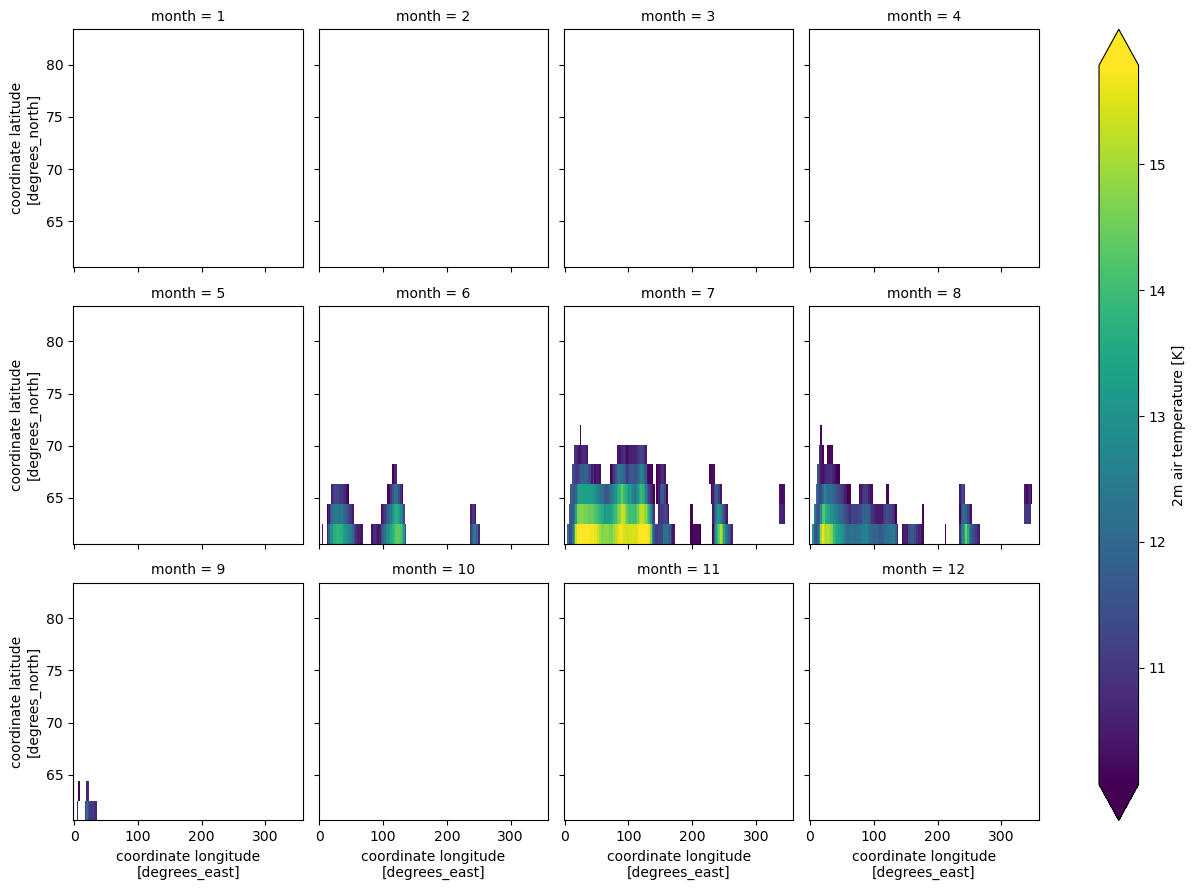

In [ ]:
(tsa_highlat_clim - 273.15).where((tsa_highlat_clim - 273.15) > 10).plot(robust=True, col="month", col_wrap=4)

In [ ]:
smtot_highlat = smtot_detrend.sel(member=0, lat=slice(60, None)).weighted(grid.LANDAREA).mean(dim=["lat", "lon"])
smtot_highlat_norm = (smtot_highlat - smtot_highlat.mean(dim="year")) / smtot_highlat.std()

smsfc_highlat = smsfc_detrend.sel(member=0, lat=slice(60, None)).weighted(grid.LANDAREA).mean(dim=["lat", "lon"])
smsfc_highlat_norm = (smsfc_highlat - smsfc_highlat.mean(dim="year")) / smsfc_highlat.std()

fctr_highlat = fctr_detrend.sel(member=0, lat=slice(60, None)).weighted(grid.LANDAREA).mean(dim=["lat", "lon"])
fctr_highlat_norm = (fctr_highlat - fctr_highlat.mean(dim="year")) / fctr_highlat.std()

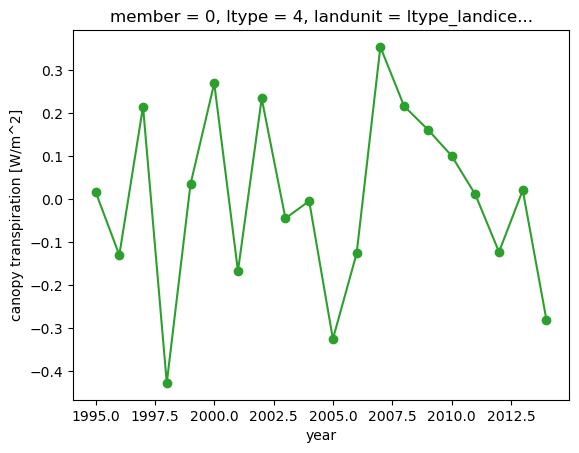

In [ ]:
fctr_highlat.plot(c="tab:green", marker="o")

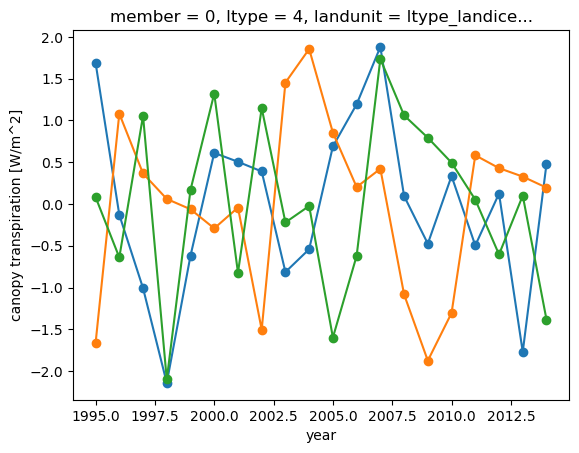

In [ ]:
smtot_highlat_norm.plot(marker="o")
smsfc_highlat_norm.plot(marker="o")
fctr_highlat_norm.plot(marker="o")

# bins

In [ ]:
variables = [
    "EFLX_LH_TOT_month_1",
    "TLAI_month_1",
]

time_slice = slice("1995-01", "2014-12")
year_start = time_slice.start[:4]
year_end = time_slice.stop[:4]
grid = xclim.load_fhist_ppe_grid()

snow_pct_threshold = 80    # maximum allowable percent of snow cover on all months of the average year
nonglc_pct_threshold = 80  # maximum allowable percent of glaciated land for a NON-glaciated gridcell

fsno = xclim.load_fhist("FSNO_month_1", keep_var_only=True)["FSNO"].sel(time=time_slice).reindex_like(grid, method="nearest", tolerance=1e-3)
fsno_clim_min = fsno.groupby("time.month").mean().min(dim="month")

# Create masks
snow_mask = fsno_clim_min <= (snow_pct_threshold / 100)
nonglc_mask = grid.PCT_GLC <= nonglc_pct_threshold
full_mask = snow_mask & nonglc_mask

fhist = {}
for v in variables:
    print(f"  {v}")
    name = "_".join(v.split("_")[:-2])
    fhist[v] = xclim.load_fhist(v, keep_var_only=True)[name].sel(time=time_slice).reindex_like(grid, method="nearest", tolerance=1e-3)
    fhist[v] = fhist[v].where(full_mask)
    fhist[v].attrs["masks"] = f"gridcell percent glaciated land <= {nonglc_pct_threshold}\ngridcell percent snow cover on all months of average year <= {snow_pct_threshold}"

fhist["EFLX_LH_TOT_year_1"] = fhist["EFLX_LH_TOT_month_1"].groupby("time.year").map(lambda x: x.weighted(x.time.dt.days_in_month).mean("time"))

  EFLX_LH_TOT_month_1
  TLAI_month_1


In [ ]:
nb = 15
mask_type = "mask_glc80_snow80"
qbin_variables = [
    "AI_clim_1",
    "cor_SMSFC_FCTR_clim_1",
    "cor_SMTOT_FCTR_clim_1",
    
    "TLAI_month_1",
    "TLAI_year_1",

    "TOTANNPRECT_year_1",
    "TSA_year_1",
]
rootdir = Path("/glade/work/bbuchovecky/et_controls/proc/qbin")

grid = xclim.load_fhist_ppe_grid()

qbin = {}
for v in qbin_variables:
    if "cor" in v:
        t = "1950-2014"
    else:
        t = "1995-2014"

    qbin[v] = xr.open_mfdataset(
        list((rootdir / mask_type / v).glob(f"qbin{nb}.{t}.TIMEagg.{v}.*.nc")),
        combine="nested",
        concat_dim="member",
    ).sortby("member").reindex_like(grid, method="nearest", tolerance=1e-3)

Text(0.5, 1.0, 'bin: AI = R_net / P')

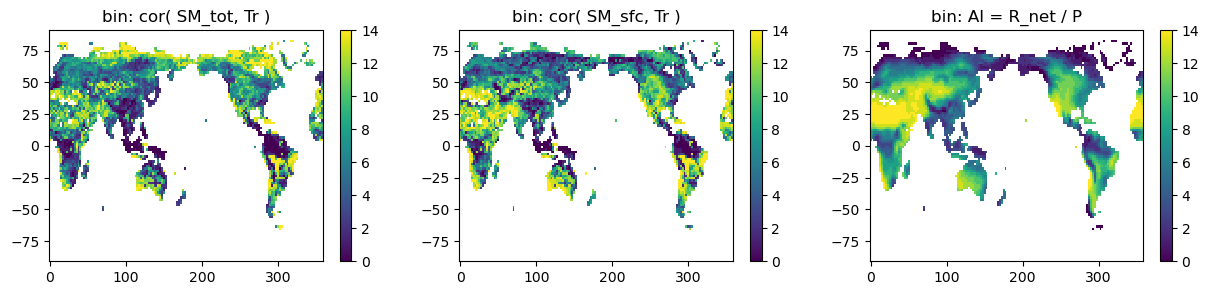

In [ ]:
m = 4

fig, ax = plt.subplots(1, 3, figsize=(15, 3))
qbin["cor_SMTOT_FCTR_clim_1"].x_bin.sel(member=m).plot.pcolormesh(ax=ax[0], add_labels=False, cmap="viridis")
qbin["cor_SMSFC_FCTR_clim_1"].x_bin.sel(member=m).plot.pcolormesh(ax=ax[1], add_labels=False, cmap="viridis")
qbin["AI_clim_1"].x_bin.sel(member=m).plot.pcolormesh(ax=ax[2], add_labels=False, cmap="viridis")

ax[0].set_title("bin: cor( SM_tot, Tr )")
ax[1].set_title("bin: cor( SM_sfc, Tr )")
ax[2].set_title("bin: AI = R_net / P")

In [ ]:
def fancy_binned_mean(bs, sg):

    bm = bs.sel(stats_name="mean").where(sg).compute()
    jh = bs.sel(stats_name="n").where(sg).compute()

    vabs = 8
    cmap = "BrBG"

    scaling_power = 0.4  # use power scaling to draw out bins with lower sample size
    ref_count = round(jh.max().values.item() / 1e2, 0) * 1e2
    radius_scalar = 0.4
    lw_scalar = 0.3
    line_alpha = 0.5

    ncols = 6
    nrows = 5

    fig, axs = plt.subplots(
        ncols=ncols, nrows=nrows,
        sharex=True, sharey=True,
        figsize=(14, 13),
        subplot_kw=dict(box_aspect=1),
        constrained_layout=True,
        dpi=100,
    )
    ax = axs.flatten()

    pcm = None
    for i, m in enumerate(bm.member.values):
        pcm = ax[i].pcolormesh(bm.sel(member=m), shading="auto", cmap=cmap, vmin=-vabs, vmax=vabs)

        m_jh = jh.sel(member=m).T
        for ii in range(len(jh.ibx)):
            for jj in range(len(jh.iby)):
                count = m_jh.values[ii, jj]
                if count > 0:
                    radius = radius_scalar * ((count / ref_count) ** scaling_power)
                    lw = lw_scalar + ((count / ref_count) ** scaling_power)
                    circle = Circle(
                        (ii + 0.5, jj + 0.5),
                        radius,
                        fill=False,
                        edgecolor="black",
                        linewidth=lw,
                        alpha=line_alpha,
                    )
                    ax[i].add_patch(circle)

        ax[i].set_title(
            xclim.ppe.get_member_name(m),
            color=xclim.ppe.get_member_cat_color(m),
            # color="k",
            fontsize=10,
            fontweight="bold",
            )
        ax[i].set_xlim(0, len(bm.ibx))
        ax[i].set_ylim(0, len(bm.iby))

        ax[i].set_yticks(np.arange(nb) + 0.5)
        ax[i].set_xticks(np.arange(nb) + 0.5)
        ax[i].tick_params(length=0)  # remove tick marks

        # Add 'low' and 'high' labels to the axes
        ticklabels = np.full((nb), "", dtype=object)
        ticklabels[0] = "low"
        ticklabels[-1] = "high"

        ax[i].set_yticklabels(ticklabels, rotation=35, ha="right", va="center")
        ax[i].set_xticklabels(ticklabels, rotation=35, ha="center", va="top")

        if i % ncols == 0:
            ax[i].set_ylabel(f"{y_var}", fontsize=12)
        if i // ncols == nrows - 1:
            ax[i].set_xlabel(f"{x_var}", fontsize=12)
        
        # Color the outer edge of the subplot corresponding to the parameter functional category
        # for spine in ax[i].spines.values():
        #     spine.set_color(xclim.ppe.get_member_cat_color(m))
        #     spine.set_linewidth(4)

    # Add colorbar below all subplots
    cbar = fig.colorbar(
        pcm,
        ax=axs,
        orientation="horizontal",
        extend="both",
        fraction=0.025,
        shrink=0.9,
        pad=0.025,
    )
    cbar.set_label("$\\Delta$ET [W/m2]", fontsize=12)

    for i in range(len(bm.member), ncols * nrows):
        ax[i].remove()



    # Create custom legend for member categories
    # Get unique categories and their colors
    categories = {}
    for m in bm.member.values:
        cat = xclim.ppe.get_member_cat_name(m)
        color = xclim.ppe.get_member_cat_color(m)
        if cat not in categories:
            categories[cat] = color

    # Create legend handles
    legend_handles = [Patch(facecolor=color, label=cat) for cat, color in categories.items()]

    # Add legend using figure coordinates
    legend = fig.legend(
        handles=legend_handles,
        ncols=3,
        loc='lower right',
        bbox_to_anchor=(0.98, 0.15),
        bbox_transform=fig.transFigure,
        frameon=True,
        fontsize=12,
        title="Functional Categories",
        title_fontproperties={
            "weight": "bold",
            "size": 12,
        }
    )


    # Draw the figure to apply and fix layout
    fig.canvas.draw()

    # Get colorbar position
    cbar_pos = cbar.ax.get_position()

    # Add text below legend for alpha and n_min parameters
    fig.text(
        (cbar_pos.x0 + cbar_pos.x1) / 2,
        cbar_pos.y0 - 0.05,
        f"$Significance$: $two$-$sided$ $t$-$test$ $\\alpha = {alpha}$, $n \\geq {n_min}$",
        ha="center",
        va="top",
        fontsize=10,
        transform=fig.transFigure,
    )

    # Create three reference circles of different sizes
    scale_counts = [ref_count * 0.25, ref_count * 0.5, ref_count]

    # Position for the scale circles
    scale_x = cbar_pos.x1 + 0.05
    scale_y_base = (cbar_pos.y0 + cbar_pos.y1) / 2

    # Calculate spacing
    max_radius_data = radius_scalar * ((scale_counts[-1] / ref_count) ** scaling_power)
    point_data = np.array([[0, 0], [max_radius_data, 0]])
    point_display = ax[0].transData.transform(point_data)
    point_figure = fig.transFigure.inverted().transform(point_display)
    max_radius_fig = np.linalg.norm(point_figure[1] - point_figure[0])

    spacing = max_radius_fig * 2.5

    for idx, scale_count in enumerate(scale_counts):
        # Calculate radius with same scaling
        data_radius = radius_scalar * ((scale_count / ref_count) ** scaling_power)
        scale_lw = lw_scalar + ((scale_count / ref_count) ** scaling_power)
        
        # Convert to figure coordinates
        point_data = np.array([[0, 0], [data_radius, 0]])
        point_display = ax[0].transData.transform(point_data)
        point_figure = fig.transFigure.inverted().transform(point_display)
        scale_radius = np.linalg.norm(point_figure[1] - point_figure[0])
        
        # Position circles vertically with spacing
        scale_y = scale_y_base + (idx - 1) * spacing
        
        scale_circle = Circle(
            (scale_x, scale_y),
            scale_radius,
            fill=False,
            edgecolor="black",
            linewidth=scale_lw,
            alpha=0.6,
            clip_on=False,
            transform=fig.transFigure,
        )
        fig.add_artist(scale_circle)
        
        fig.text(
            scale_x + max_radius_fig + 0.01,
            scale_y,
            f"{int(scale_count):,d}",
            ha="left",
            va="center",
            fontsize=9,
            transform=fig.transFigure,
        )

    # Add label above reference circles
    fig.text(
        scale_x - max_radius_fig,
        scale_y_base + idx  * spacing + 0.005,
        "Sample size:",
        ha="left",
        va="center",
        fontsize=9,
        transform=fig.transFigure,
    )

    fig.savefig(
        f"fig/qbin{nb}.{year_start}-{year_end}.TIMEagg.alpha{str(alpha).replace(".", "")}.nmin{n_min}.{x_type}x{x_var}.{y_type}y{y_var}.{z_type}z{z_var}.png",
        dpi=400, bbox_inches="tight")

In [ ]:
z_var = "EFLX_LH_TOT_month_1"
x_var = "AI_clim_1"
y_var = "TLAI_month_1"
alpha = 0.05
n_min = 50

# Select data
z = fhist[z_var].sel(member=slice(1, None)).drop_vars(['ltype', 'landunit']) - fhist[z_var].sel(member=0).drop_vars(['ltype', 'landunit'])
x_bin = qbin[x_var].sel(member=slice(1, None)).x_bin
y_bin = qbin[y_var].sel(member=slice(1, None)).x_bin

# Store metadata (d = delta, a = absolute)
z_type = "d"
x_type = "a"
y_type = "a"

# Compute bin stats
bs_ai_tlai, sg_ai_tlai = xclim.binned.full_bin_stats(z, x_bin, y_bin, nb, nb, z_time_coord="time", alpha=alpha, n_min=n_min)

# Get the bins for the default member
x_bin0 = qbin[x_var].sel(member=0).x_bin
y_bin0 = qbin[y_var].sel(member=0).x_bin
z0 = fhist[z_var].sel(member=0).drop_vars(['ltype', 'landunit'])
bs0_ai_tlai, sg0_ai_tlai = xclim.binned.full_bin_stats(z0, x_bin0, y_bin0, nb, nb, z_time_coord="time", alpha=alpha, n_min=n_min)

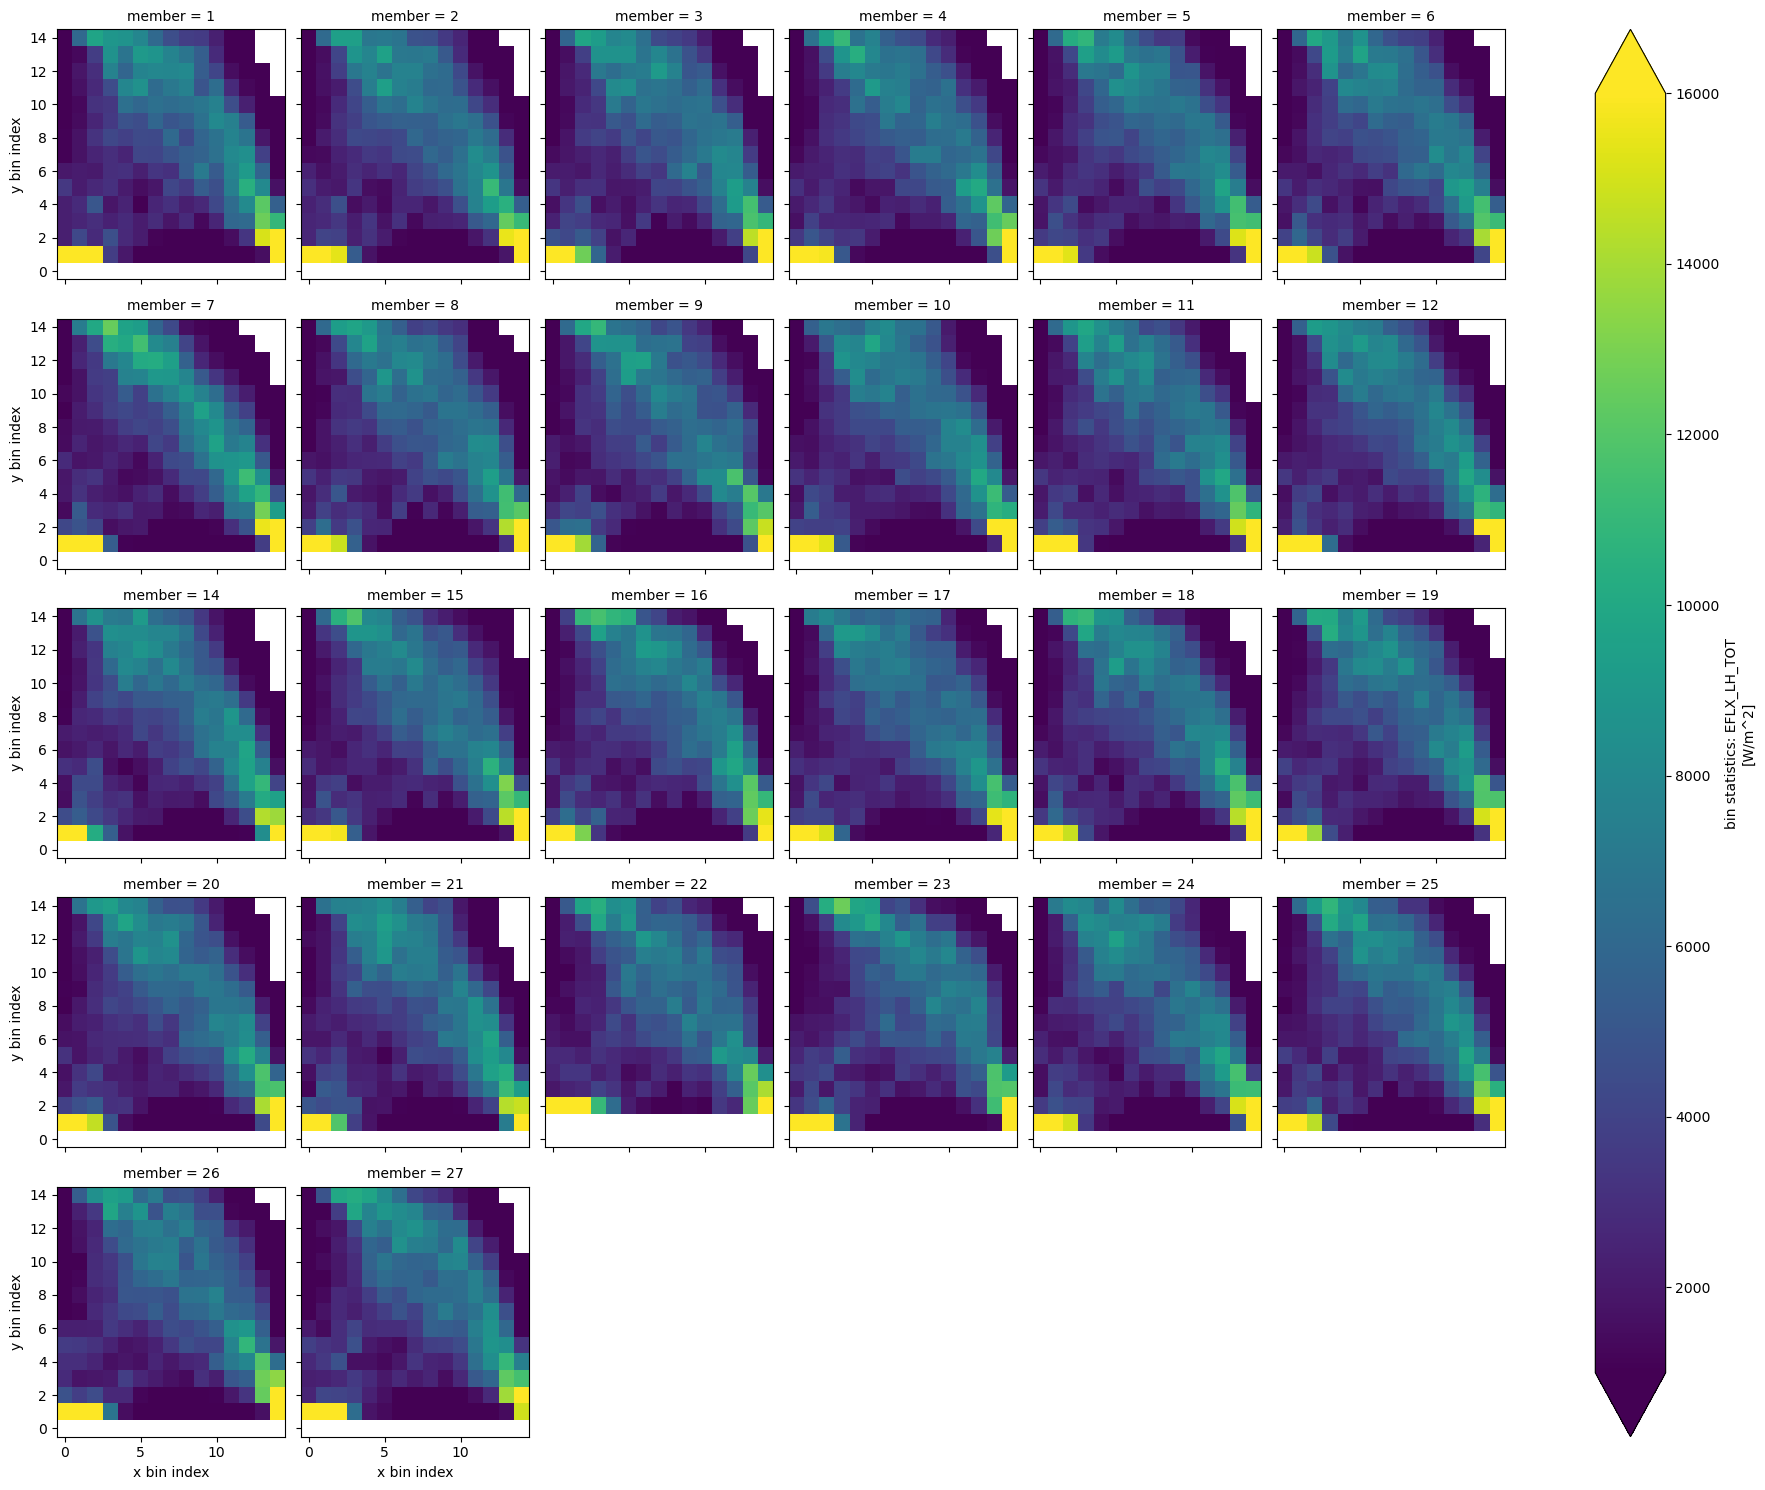

In [ ]:
bs_ai_tlai.sel(stats_name="n").plot(col="member", col_wrap=6, robust=True, cmap="viridis", vmin=1000, vmax=16000)
plt.savefig("fig/tmp.qbin15.1995-2014.TIMEagg.alpha005.nmin50.axAI_clim_1.ayTLAI_month_1.zn.png", bbox_inches="tight", dpi=300)

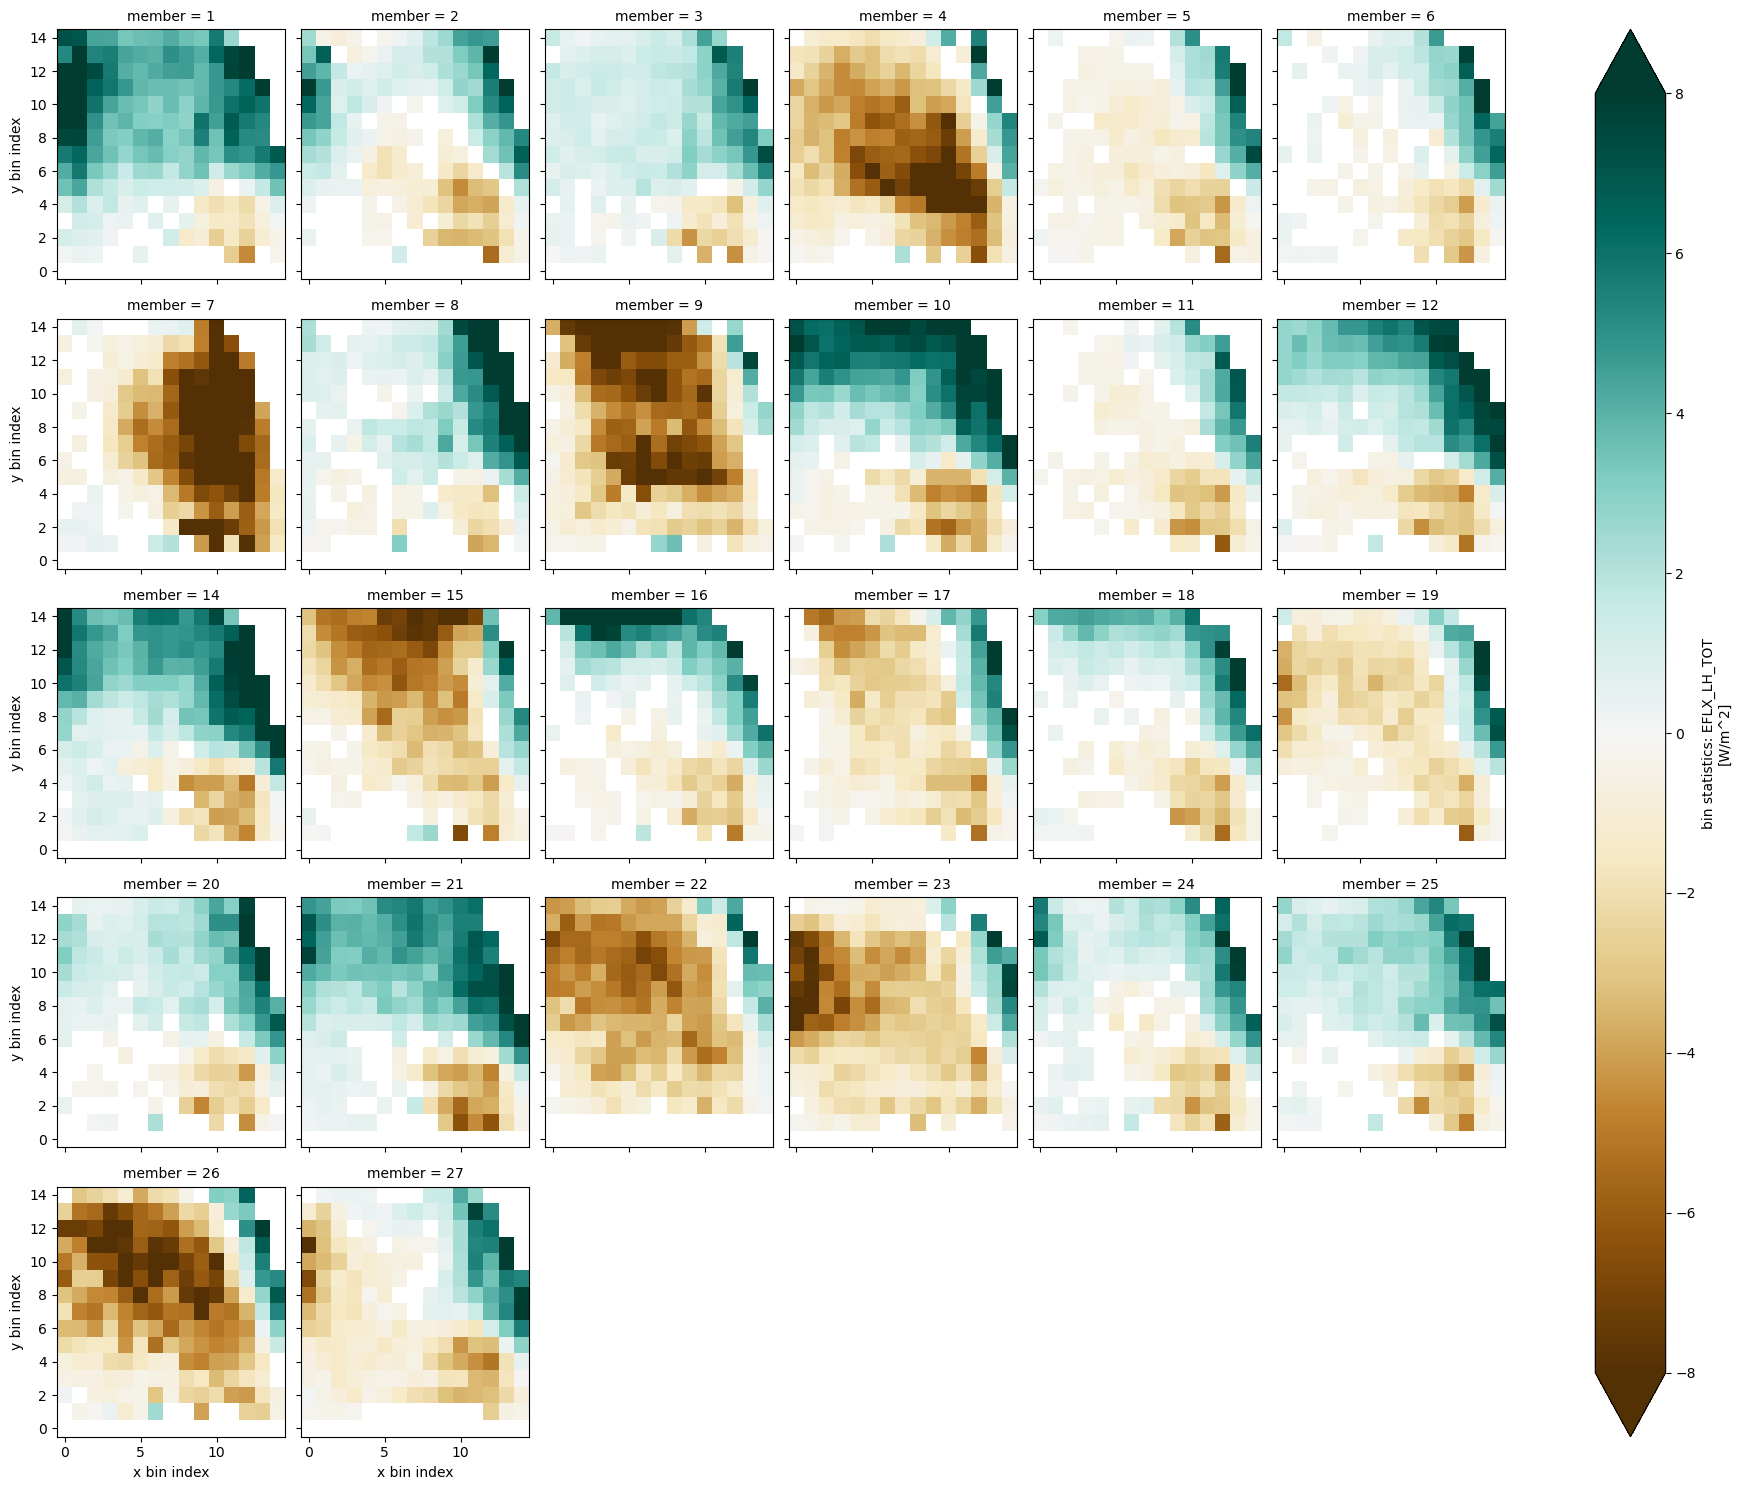

In [ ]:
bs_ai_tlai.sel(stats_name="mean").where(sg_ai_tlai).plot(col="member", col_wrap=6, vmin=-8, vmax=8, cmap="BrBG")
plt.savefig("fig/tmp.qbin15.1995-2014.TIMEagg.alpha005.nmin50.axAI_clim_1.ayTLAI_month_1.dzEFLX_LH_TOT_month_1.png", bbox_inches="tight", dpi=300)

In [ ]:
z_var = "EFLX_LH_TOT_month_1"
x_var = "cor_SMTOT_FCTR_clim_1"
y_var = "TLAI_month_1"
alpha = 0.05
n_min = 50

# Select data
z = fhist[z_var].sel(member=slice(1, None)).drop_vars(['ltype', 'landunit']) - fhist[z_var].sel(member=0).drop_vars(['ltype', 'landunit'])
x_bin = qbin[x_var].sel(member=slice(1, None)).x_bin
y_bin = qbin[y_var].sel(member=slice(1, None)).x_bin

# Store metadata (d = delta, a = absolute)
z_type = "d"
x_type = "a"
y_type = "a"

# Compute bin stats
bs_smtot_fctr_tlai, sg_smtot_fctr_tlai = xclim.binned.full_bin_stats(z, x_bin, y_bin, nb, nb, z_time_coord="time", alpha=alpha, n_min=n_min)

# Get the bins for the default member
x_bin0 = qbin[x_var].sel(member=0).x_bin
y_bin0 = qbin[y_var].sel(member=0).x_bin
z0 = fhist[z_var].sel(member=0).drop_vars(['ltype', 'landunit'])
bs0_smtot_fctr_tlai, sg0_smtot_fctr_tlai = xclim.binned.full_bin_stats(z0, x_bin0, y_bin0, nb, nb, z_time_coord="time", alpha=alpha, n_min=n_min)

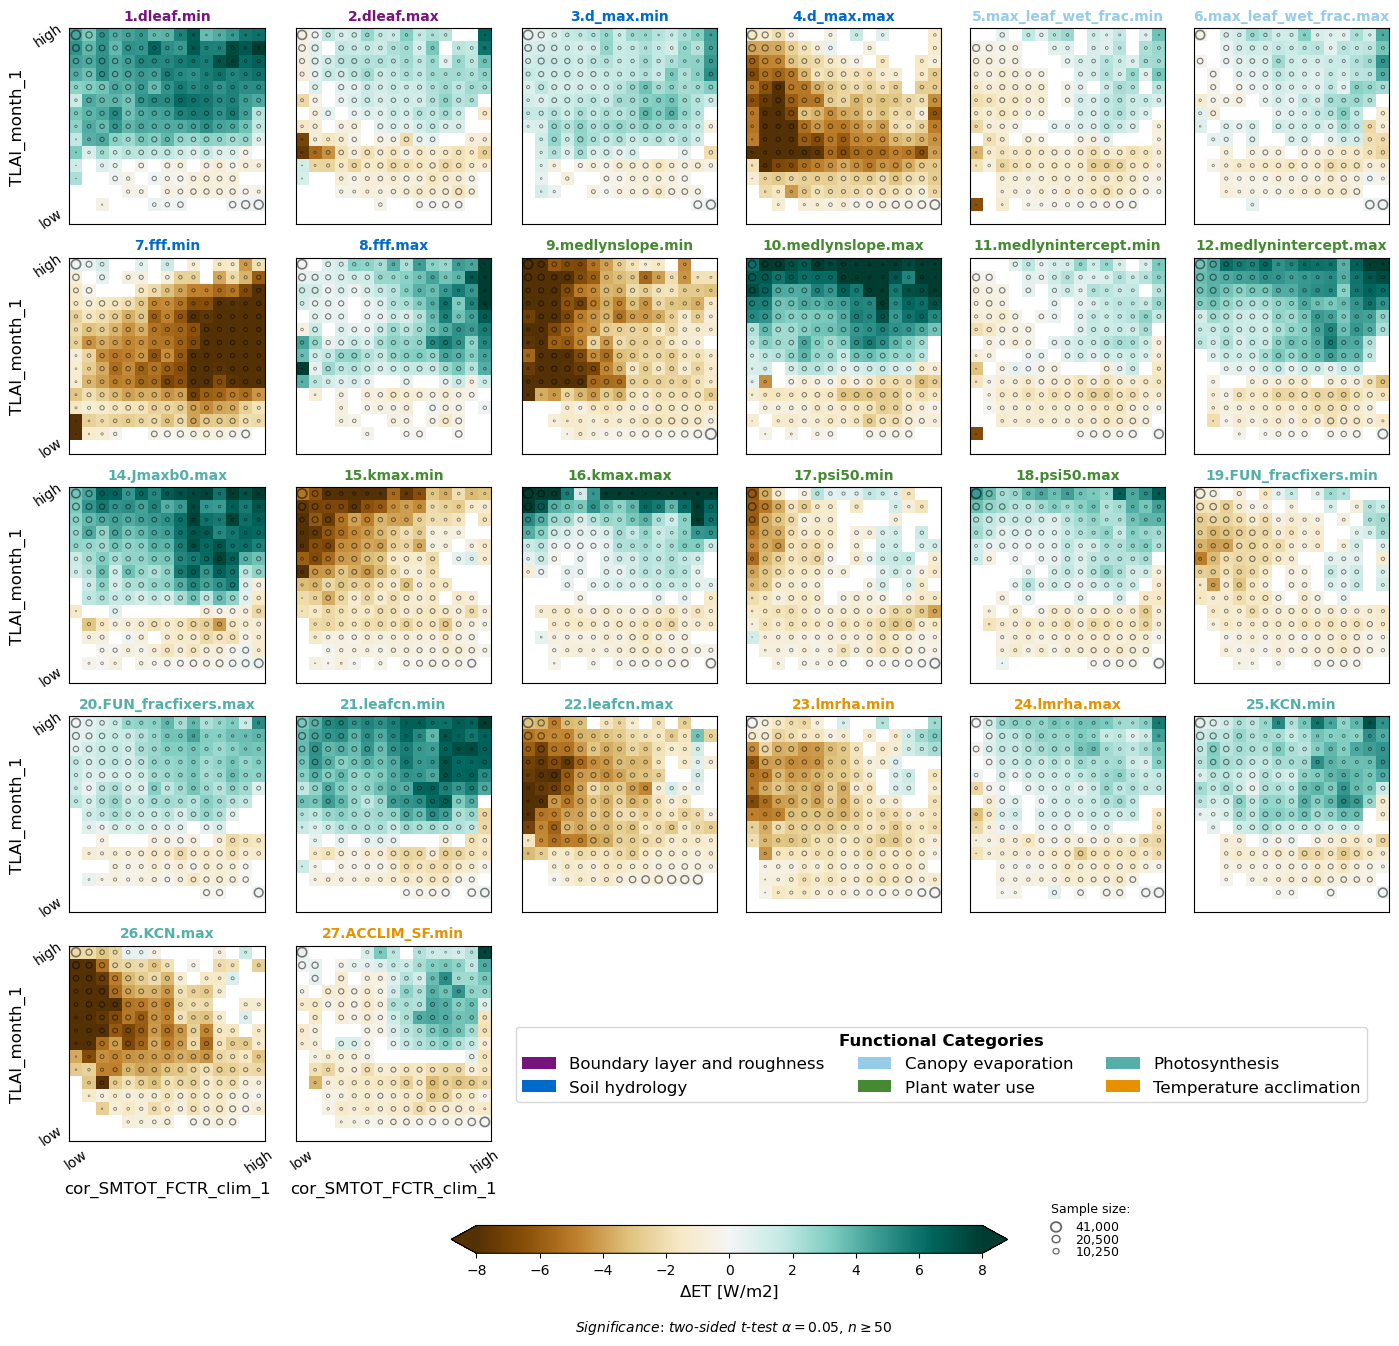

In [ ]:
z_var = "EFLX_LH_TOT_month_1"
x_var = "cor_SMTOT_FCTR_clim_1"
y_var = "TLAI_month_1"
alpha = 0.05
n_min = 50

fancy_binned_mean(bs_smtot_fctr_tlai, sg_smtot_fctr_tlai)

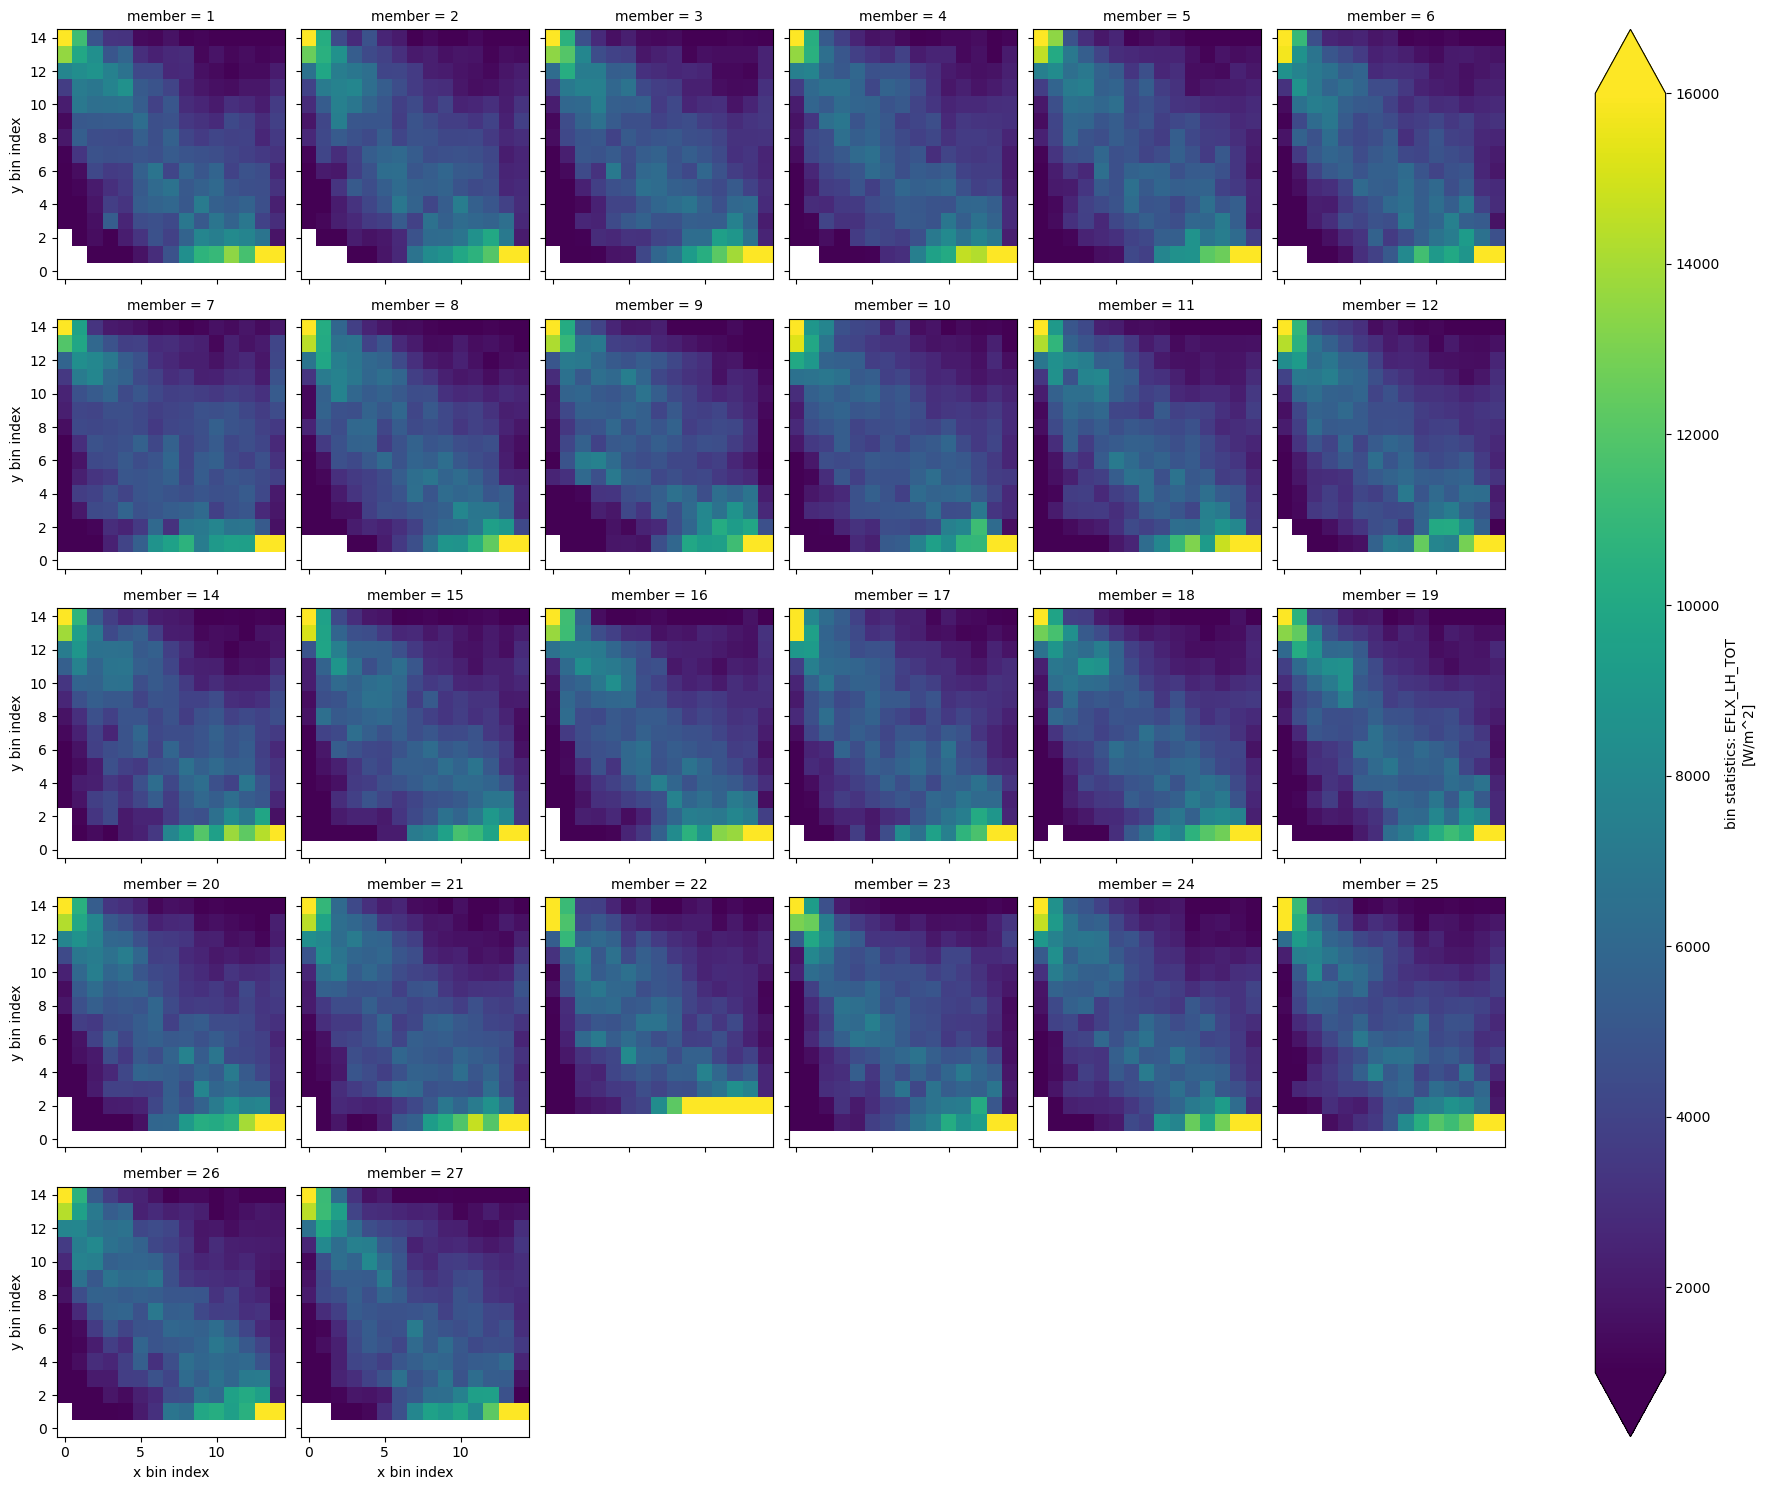

In [ ]:
bs_smtot_fctr_tlai.sel(stats_name="n").plot(col="member", col_wrap=6, robust=True, cmap="viridis", vmin=1000, vmax=16000)
plt.savefig("fig/tmp.qbin15.1995-2014.TIMEagg.alpha005.nmin50.axcor_SMTOT_FCTR_clim_1.ayTLAI_month_1.zn.png", bbox_inches="tight", dpi=300)

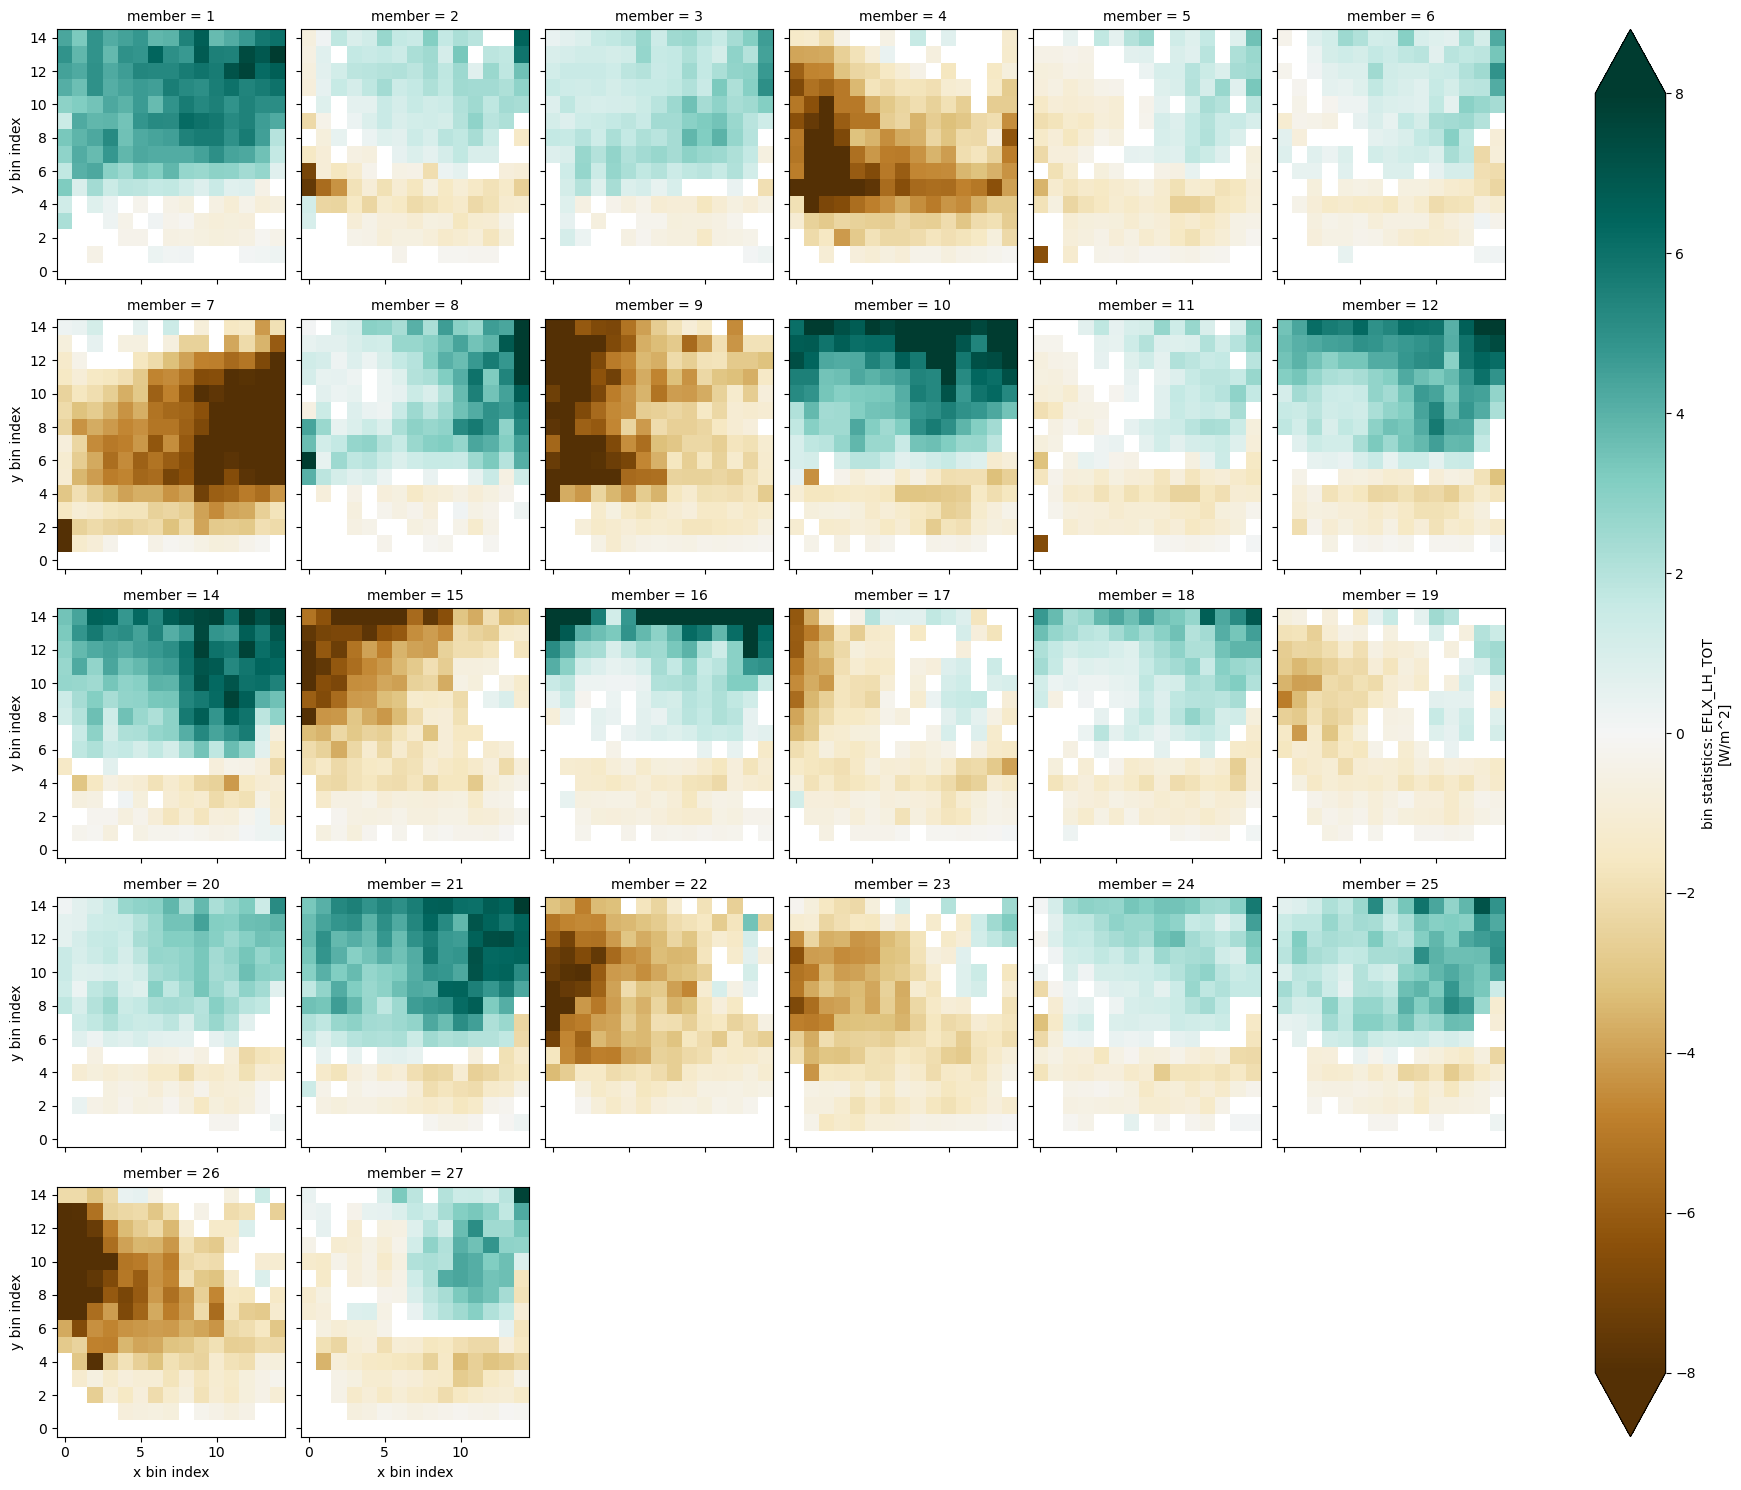

In [ ]:
bs_smtot_fctr_tlai.sel(stats_name="mean").where(sg_smtot_fctr_tlai).plot(col="member", col_wrap=6, vmin=-8, vmax=8, cmap="BrBG")
plt.savefig("fig/tmp.qbin15.1995-2014.TIMEagg.alpha005.nmin50.axcor_SMTOT_FCTR_clim_1.ayTLAI_month_1.dzEFLX_LH_TOT_month_1.png", bbox_inches="tight", dpi=300)

In [ ]:
z_var = "EFLX_LH_TOT_month_1"
x_var = "cor_SMSFC_FCTR_clim_1"
y_var = "TLAI_month_1"
alpha = 0.05
n_min = 50

# Select data
z = fhist[z_var].sel(member=slice(1, None)).drop_vars(['ltype', 'landunit']) - fhist[z_var].sel(member=0).drop_vars(['ltype', 'landunit'])
x_bin = qbin[x_var].sel(member=slice(1, None)).x_bin
y_bin = qbin[y_var].sel(member=slice(1, None)).x_bin

# Store metadata (d = delta, a = absolute)
z_type = "d"
x_type = "a"
y_type = "a"

# Compute bin stats
bs_smsfc_fctr_tlai, sg_smsfc_fctr_tlai = xclim.binned.full_bin_stats(z, x_bin, y_bin, nb, nb, z_time_coord="time", alpha=alpha, n_min=n_min)

# Get the bins for the default member
x_bin0 = qbin[x_var].sel(member=0).x_bin
y_bin0 = qbin[y_var].sel(member=0).x_bin
z0 = fhist[z_var].sel(member=0).drop_vars(['ltype', 'landunit'])
bs0_smsfc_fctr_tlai, sg0_smsfc_fctr_tlai = xclim.binned.full_bin_stats(z0, x_bin0, y_bin0, nb, nb, z_time_coord="time", alpha=alpha, n_min=n_min)

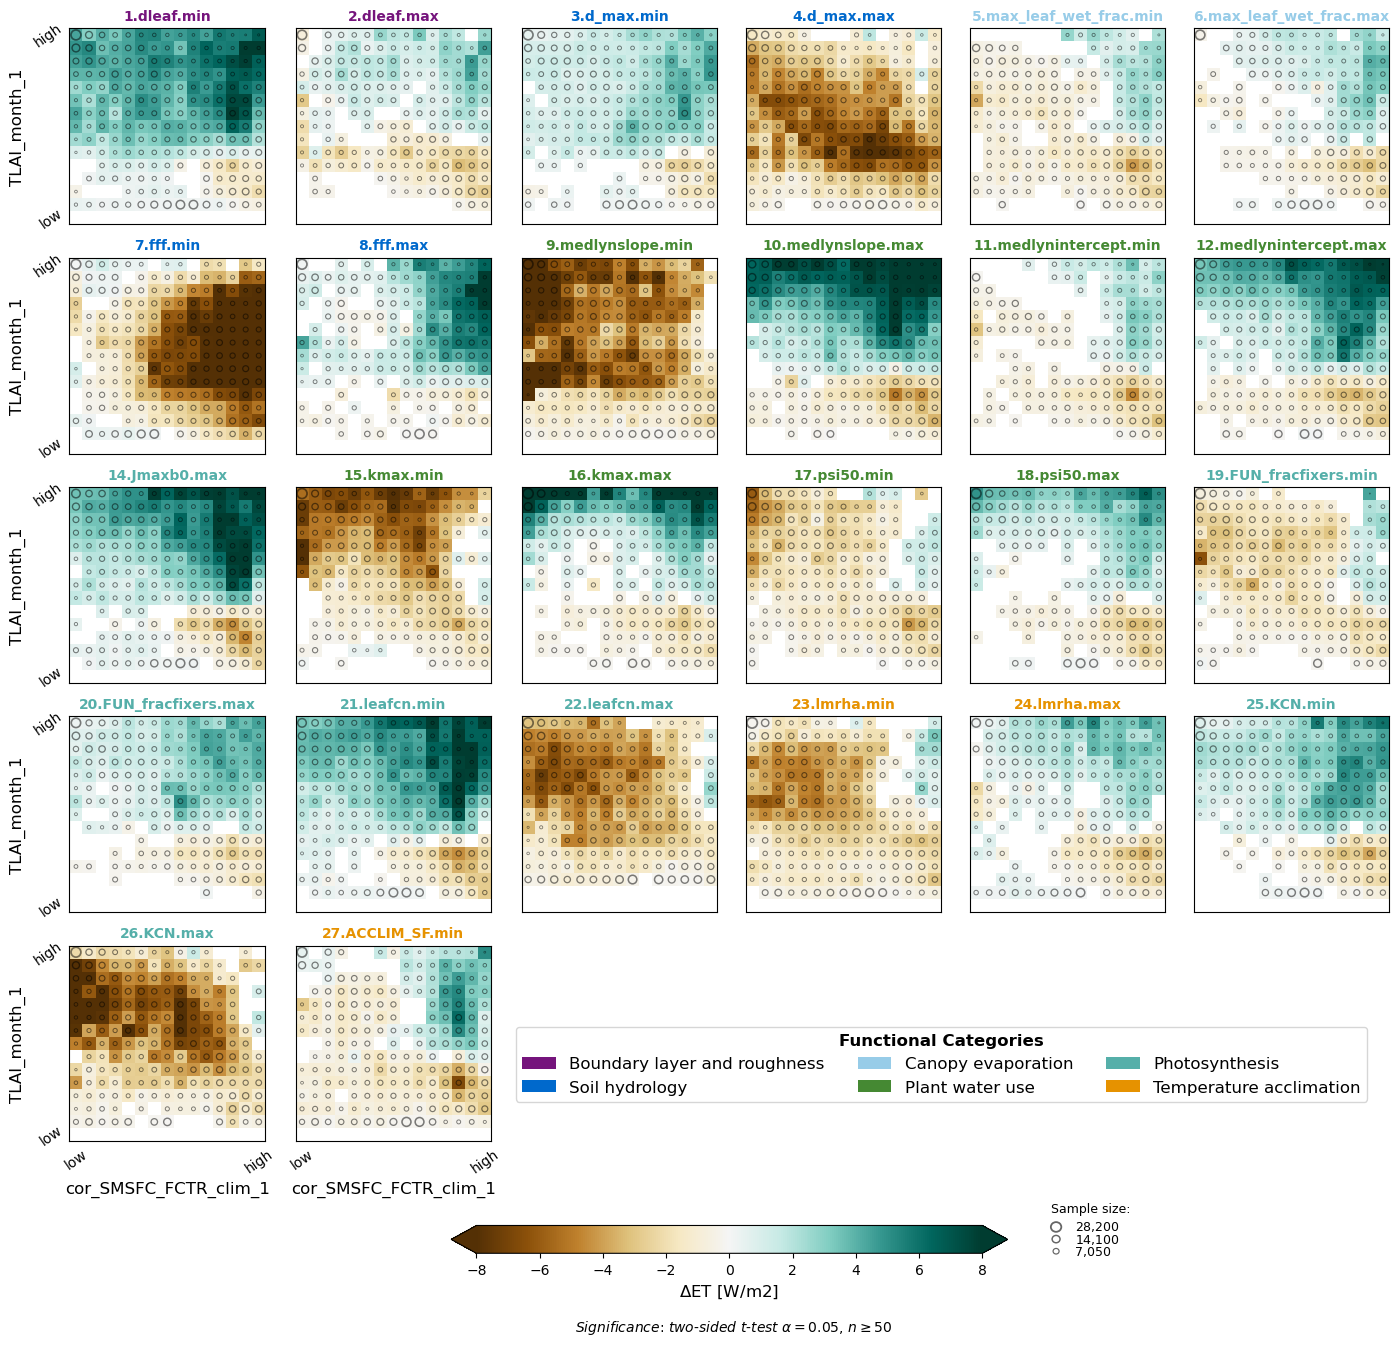

In [ ]:
z_var = "EFLX_LH_TOT_month_1"
x_var = "cor_SMSFC_FCTR_clim_1"
y_var = "TLAI_month_1"
alpha = 0.05
n_min = 50

fancy_binned_mean(bs_smsfc_fctr_tlai, sg_smsfc_fctr_tlai)

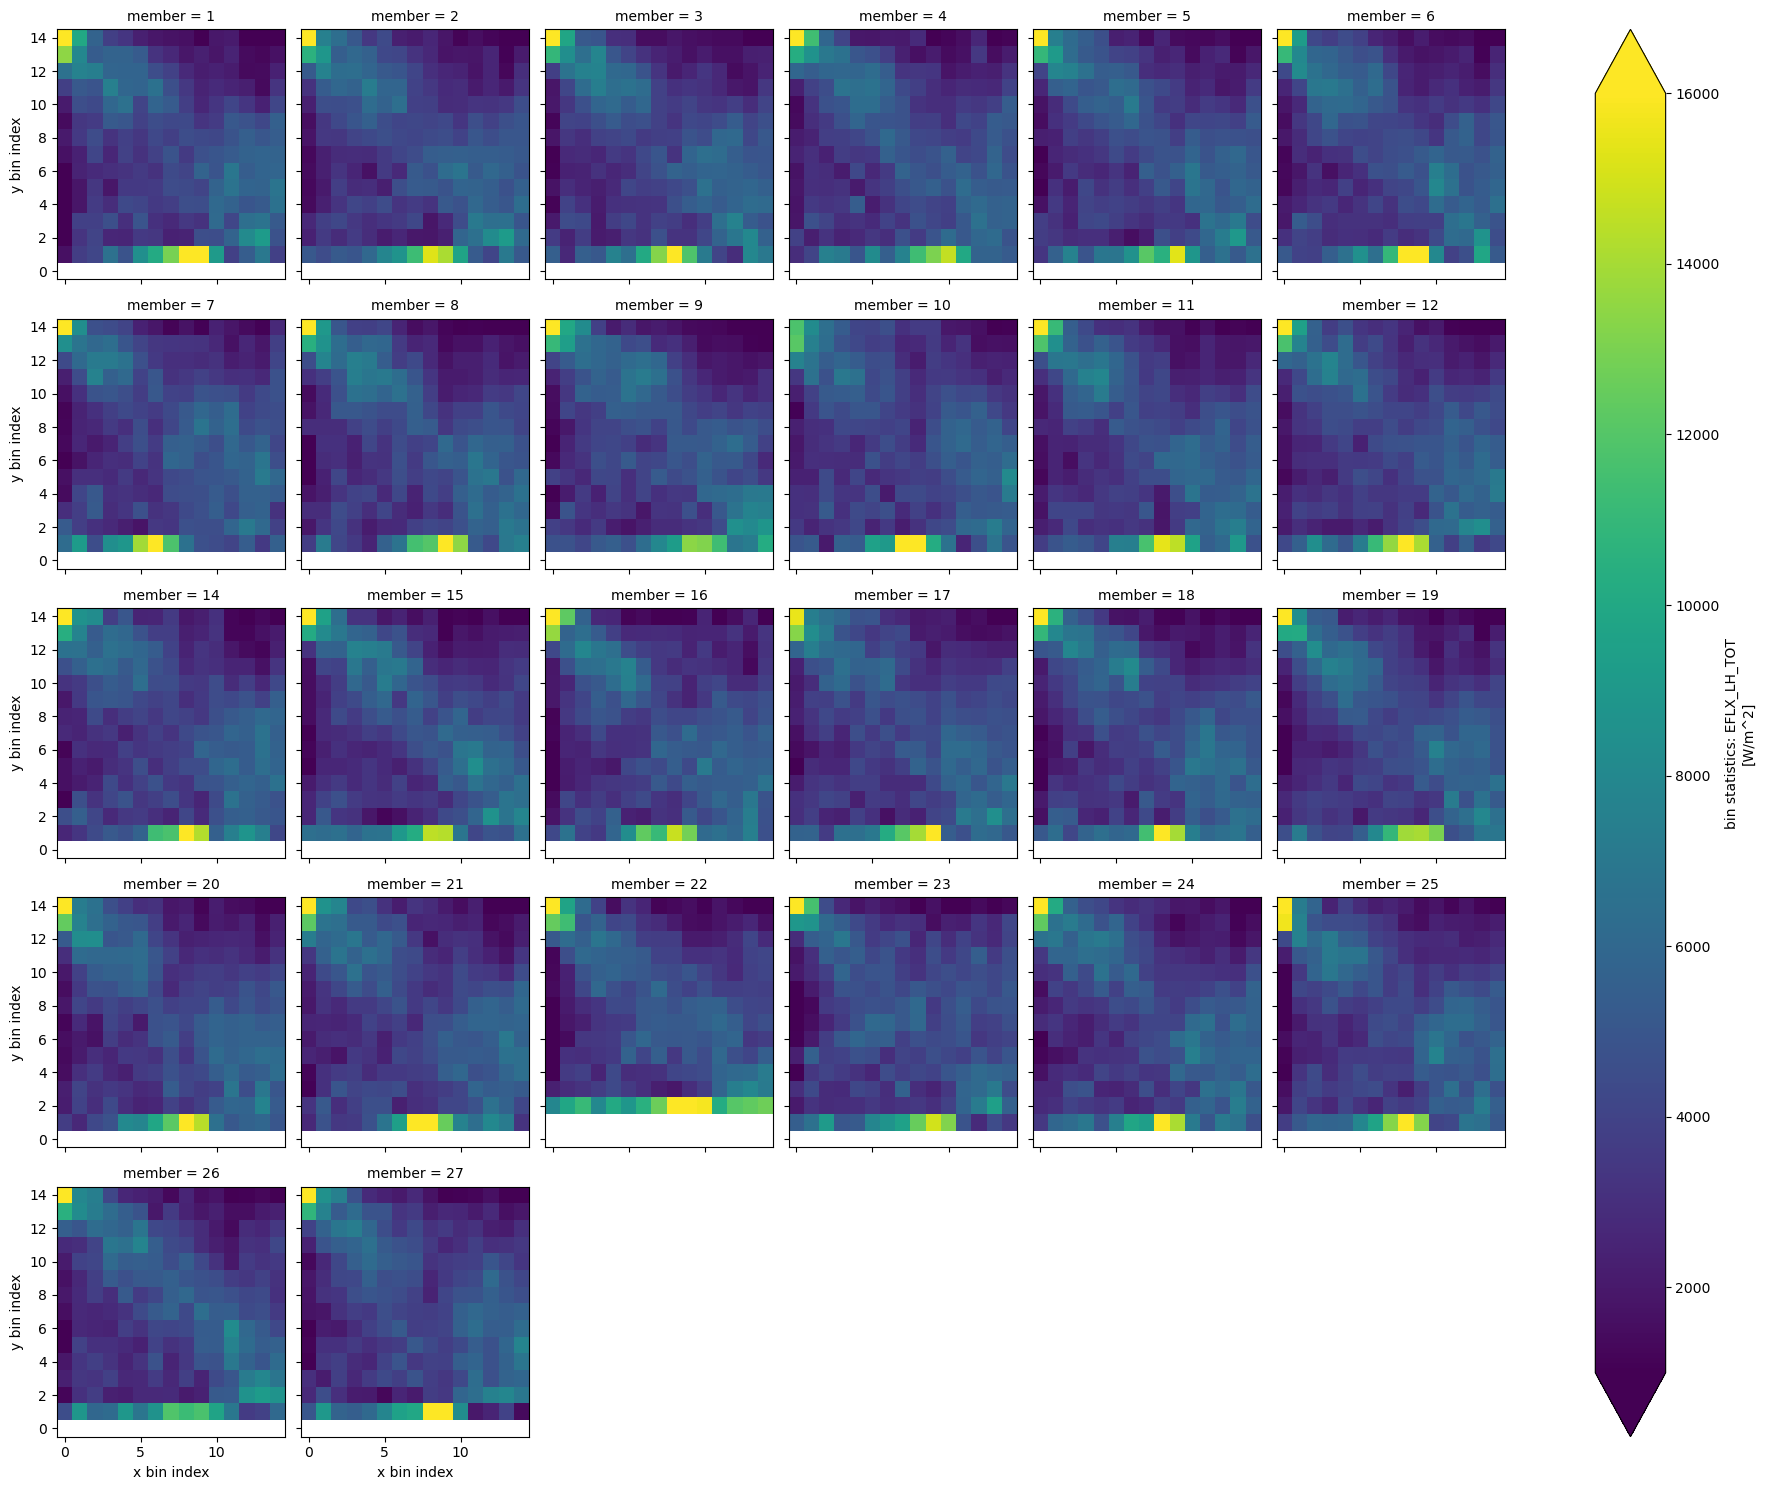

In [ ]:
bs_smsfc_fctr_tlai.sel(stats_name="n").plot(col="member", col_wrap=6, robust=True, cmap="viridis", vmin=1000, vmax=16000)
plt.savefig("fig/tmp.qbin15.1995-2014.TIMEagg.alpha005.nmin50.axcor_SMSFC_FCTR_clim_1.ayTLAI_month_1.zn.png", bbox_inches="tight", dpi=300)

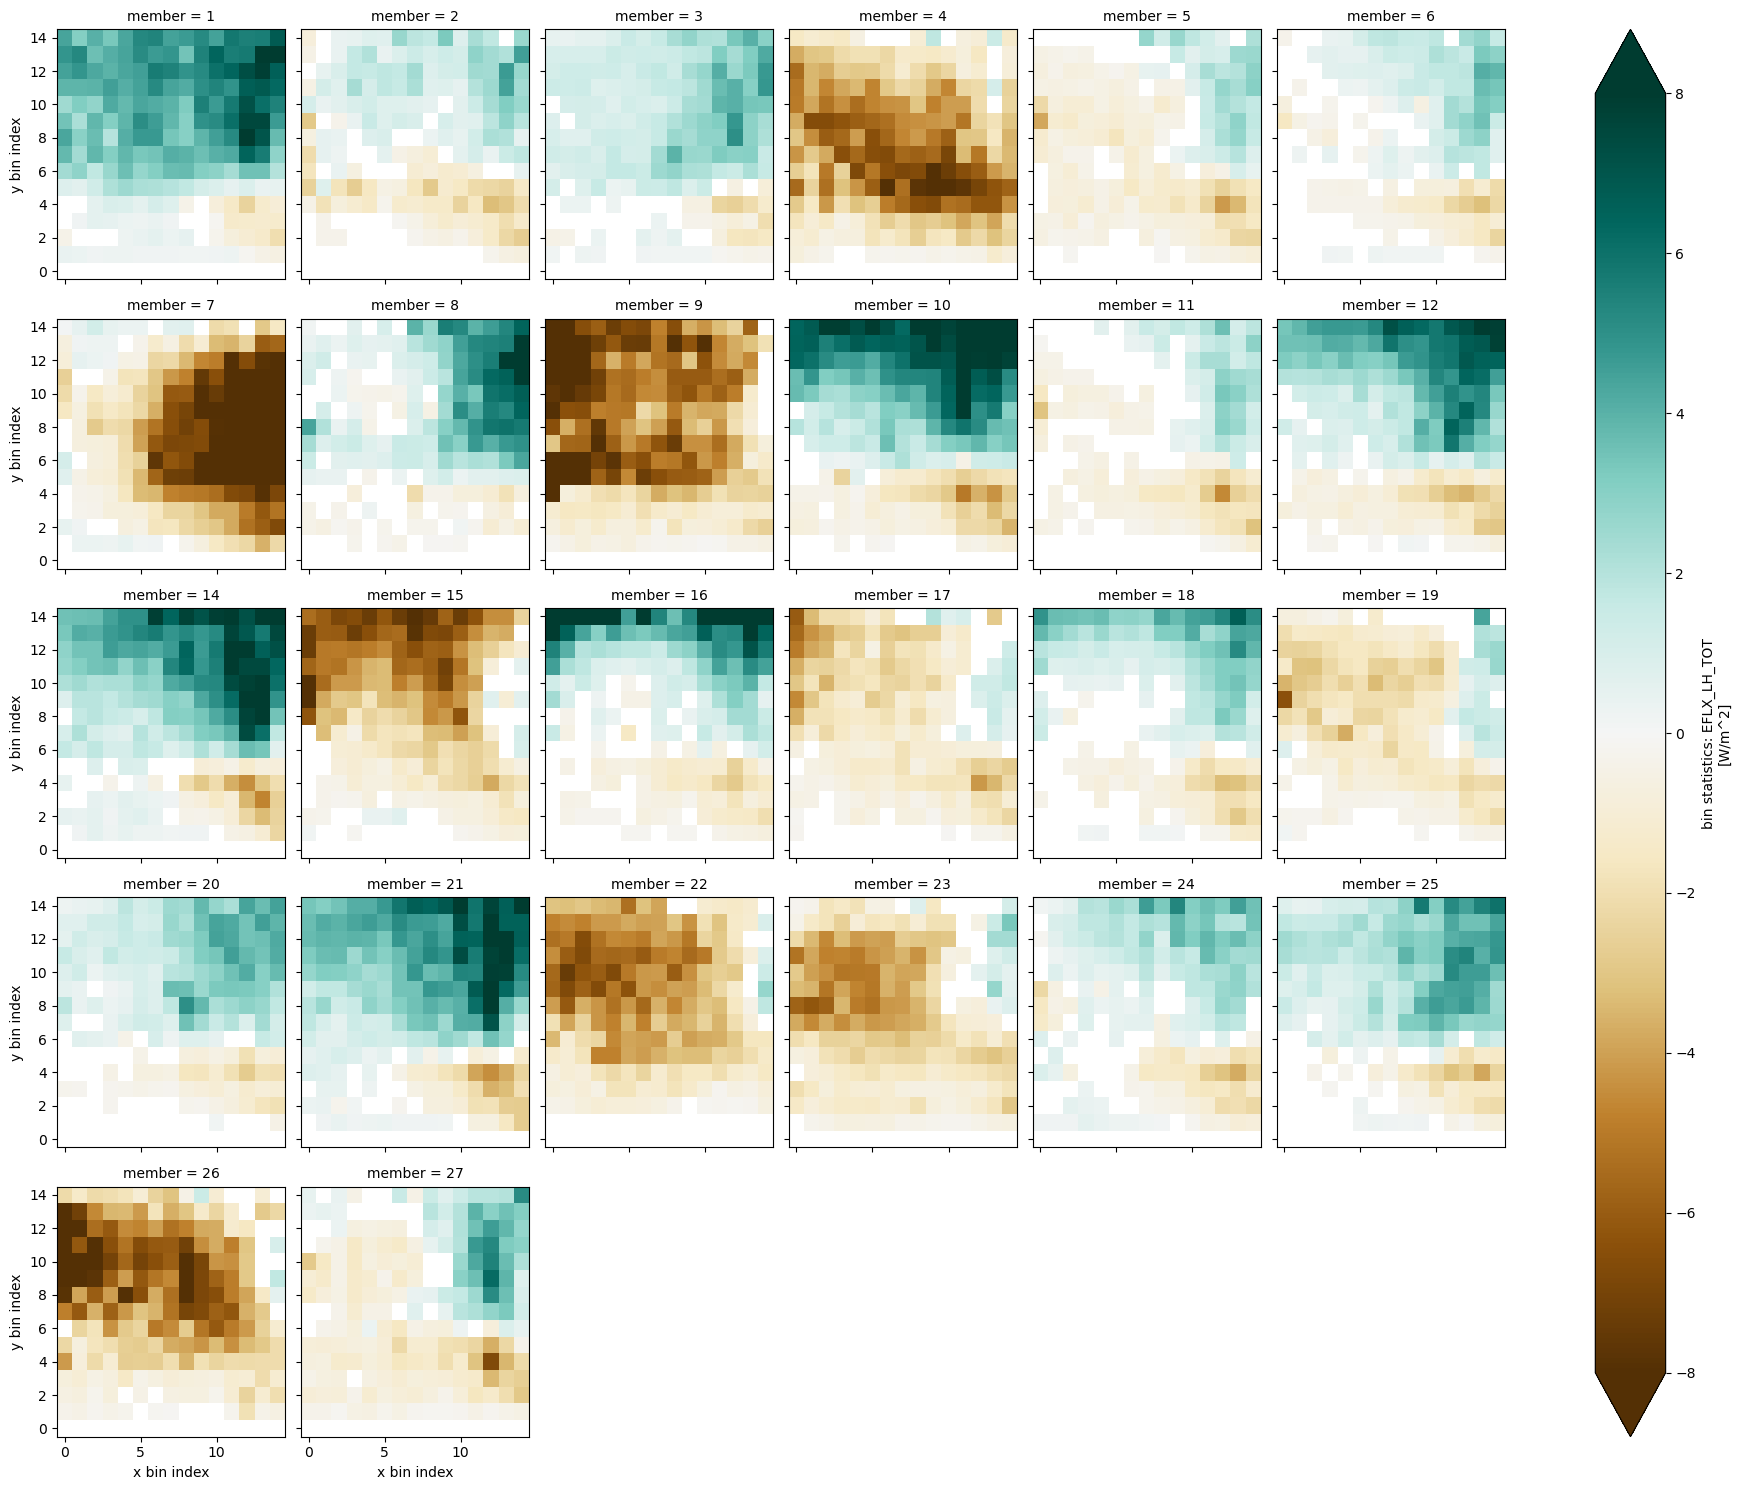

In [ ]:
bs_smsfc_fctr_tlai.where(sg_smsfc_fctr_tlai).sel(stats_name="mean").plot(col="member", col_wrap=6, vmin=-8, vmax=8, cmap="BrBG")
plt.savefig("fig/tmp.qbin15.1995-2014.TIMEagg.alpha005.nmin50.axcor_SMSFC_FCTR_clim_1.ayTLAI_month_1.dzEFLX_LH_TOT_month_1.png", bbox_inches="tight", dpi=300)